In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import pandoc
%matplotlib inline

### 1. 对于GWAS中统计功效（statistical power）的计算，通俗来讲，Power值就是我们在Pvalue<α时（α:通常设为5e-8）显著水平下，原假设（H0）为假，接受备择假设(H1)的概率。由此通过以下两图可以清晰地知道：Power value = 1- β，于是乎当我们求出真实的β之后之后，便可以得到power值
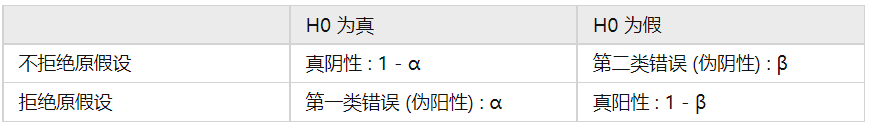
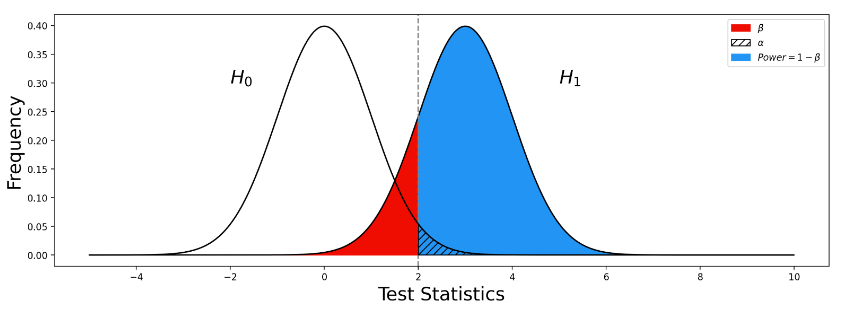


Reference：

https://zhuanlan.zhihu.com/p/342908086?utm_id=0

https://gwaslab.org/2023/02/21/2194/

Johnson, J. L., & Abecasis, G. R. GAS Power Calculator: web-based power calculator for genetic association studies. BioRxiv, 2017, 164343.

Sham, P. C., & Purcell, S. M. Statistical power and significance testing in large-scale genetic studies. Nature Reviews Genetics, 2014, 15(5), 335-346.

### 如何去计算功效power值
GWAS 分析的 Power 与样本量、突变基因频率（MAF）、效应值（Effect size,通常记为 beta）和 P-value 显著性水平阈值（alpha，通常是 5e-8）这四个因素有关。

假设效应估计值 β的抽样分布是正态分布，我们可以得出 β^∼N(β,$SE^2$)。其中，β为真实效应大小，SE 为估计值的标准误差。

在H0假设下，即当 β=0 时，利用卡方分布（chi-square distribution），如 $z^2$∼$x1^2$. 这里的计算方法经常使用卡方分布，因为这样只需要考虑分布的尾部来计算（双侧）P 值，这也使得分布的可视化比正态分布更简单。

当β!=0时，当变体具有非零效应时，$z^2$∼$x1^2$ ((β/SE$)^2$)，这是具有1个自由度和非中心参数的卡方分布；其中非中心参数NPC=$(β/SE)^2$。 

因此，在本测试中，计算真实β值需要具有一个自由度和非中心参数的卡方运算。


Reference:

Sham, P., Purcell, S. Statistical power and significance testing in large-scale genetic studies. Nat Rev Genet, 2014, 335–346.

Brion M J A, Shakhbazov K, Visscher P M. Calculating statistical power in Mendelian randomization studies. International journal of epidemiology, 2013, 42(5).

In [2]:
'''
这里根据scipy定义了两个非中心参数是否为零的卡方函数，
qchisq()用来根据P-value来计算卡方分布的分位数；
pchisq()用来根据得到的分位数、标准方差、非中心参数来计算真实β值
'''
def qchisq(p,df,ncp=0):
    """
    Calculates the quantile function of the chi-square distribution
    计算卡方分布的分位数
    """
    from scipy.stats import chi2,ncx2
    if ncp==0:
        result=chi2.ppf(q=p,df=df,loc=0,scale=1)
    else: 
        result=ncx2.ppf(q=p,df=df,nc=ncp,loc=0,scale=1)
    return result

def pchisq(q,df,ncp=0):
    """
    Calculates the cumulative of the chi-square distribution
    计算卡方分布的累积值
    """
    from scipy.stats import chi2,ncx2
    if ncp==0:
        result=chi2.cdf(x=q,df=df,loc=0,scale=1)
    else:
        result=ncx2.cdf(x=q,df=df,nc=ncp,loc=0,scale=1)
    return result

In [3]:
def get_power(MAF, beta_alt, count, pvalue=5e-8):
    """
    Power = 1 - β
    """
    sigma = math.sqrt(1 - 2*MAF*(1-MAF)*beta_alt**2)
    ses = sigma/math.sqrt(count*2*MAF*(1-MAF)) 
    q_thresh = qchisq(1-pvalue, 1)
    pwr = 1- pchisq(q_thresh, 1, (beta_alt/ses)**2) # 1- β得到power值
    return pwr

#### （1）给定效应值（Effect size，beta）为 0.2，计算在不同 MAF 和样本量下它所对应的 Power，并画出图。这里的 MAF 分为五个档位，突变频率从小到大分别是：0.01, 0.05, 0.1，0.15 和 0.2。把结果画在同一个图中，X 轴为样本量，Y 轴为 Power，画图时每一个 MAF 对应一条线。alpha 的阈值都定为 5e-8

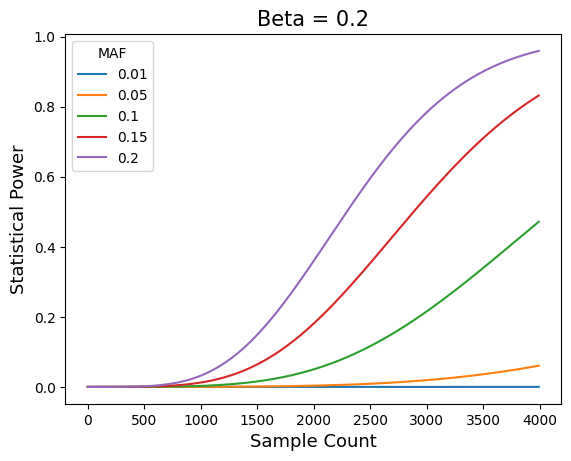

In [4]:
# 计算在指定beta_value下，不同sample数目对应的power值，并用字典保存
beta_value = 0.2 # 指定 beta_value
count = np.arange(1, 4000, 10) # 生成不同的sample数目
pwr_dict=defaultdict(dict)
for maf in [0.01, 0.05, 0.1, 0.15 ,0.2]:
    pwr_dict[maf]=defaultdict(list)
    for cnt in count:
        pwr_dict[maf][cnt]=get_power(maf, beta_value, cnt)
        
# 字典用pandas转为dataframe,再画图
df = pd.DataFrame(pwr_dict)
df.plot()
plt.title("Beta = 0.2",fontsize=15)
plt.xlabel("Sample Count",fontsize=13)
plt.ylabel("Statistical Power",fontsize=13)
plt.legend(title = 'MAF')

#### （2）给定样本量（sample size）为 2000，计算在不同 MAF 和效应值（Effect size， beta）下它所对应的 Power，并画出图。这里的 MAF 分为五个档位，突变频率从小到大分别是：0.01, 0.05, 0.1，0.15 和 0.2。把结果画在同一个图中，X 轴为效应值，Y 轴为 Power，画图时每一个 MAF 对应一条线。alpha 的阈值都定为 5e-8。

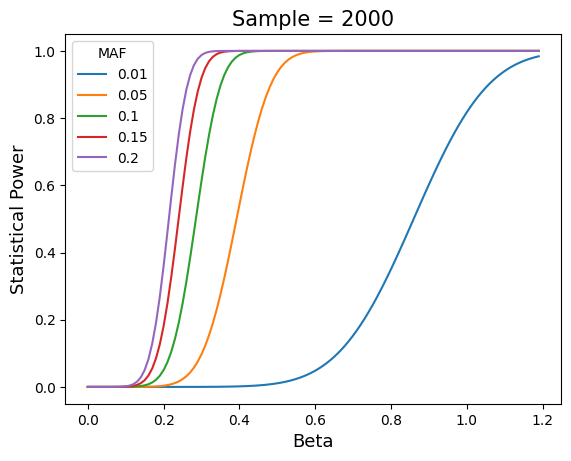

In [5]:
# 计算在指定sample数据下，每个beta值对应的power值，并用字典保存
beta_value = np.arange(0, 1.2, 0.01)
count = 2000 # 指定sample 数目
pwr_dict=defaultdict(dict)
for maf in [0.01, 0.05, 0.1, 0.15 ,0.2]:
    pwr_dict[maf]=defaultdict(list)
    for beta in beta_value:
        pwr_dict[maf][beta]=get_power(maf, beta, count)
        
# 字典用pandas转为dataframe,再画图
df = pd.DataFrame(pwr_dict)
df.plot()
plt.title("Sample = 2000",fontsize=15)
plt.xlabel("Beta",fontsize=13)
plt.ylabel("Statistical Power",fontsize=13)
plt.legend(title = 'MAF')

谢谢您的浏览，欢迎批评指正。